In [1]:
#data wrangling packages
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
df = pd.read_csv("../data/nips-papers/papers.csv")
df.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In [3]:
#remove numerals
df['paper_text_tokens'] = df.paper_text.map(lambda x: re.sub(r'\d+', '', x))

#convert to lowercase
df['paper_text_tokens'] = df.paper_text_tokens.map(lambda x: x.lower())
#print(df['paper_text_tokens'][0][:200])

#tokenize
df['paper_text_tokens'] = df.paper_text_tokens.map(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
#print(df['paper_text_tokens'][0][:25])

#stemming using Snowball stemmer
snowball = SnowballStemmer("english")  
df['paper_text_tokens'] = df.paper_text_tokens.map(lambda x: [snowball.stem(token) for token in x])
#print(df['paper_text_tokens'][0][:25])

#remove extremely short words (less than 2 characters)
df['paper_text_tokens'] = df.paper_text_tokens.map(lambda x: [t for t in x if len(t) > 1])
#print(df.paper_text_tokens[0])

In [4]:
#converting processed documents to feature vectors

no_features = 1000

# NMF: tf-idf vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
lemmas = df['paper_text_tokens'].apply(lambda x: ' '.join(x))
tfidf = tfidf_vectorizer.fit_transform(lemmas)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA: CountVectorizer (term-frequencies)
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(lemmas)
tf_feature_names = tf_vectorizer.get_feature_names()

In [5]:
#training the topic models with NMF and LDA
from sklearn.decomposition import NMF, LatentDirichletAllocation
import warnings
warnings.simplefilter("ignore", DeprecationWarning)

no_topics = 7

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=10,random_state=0).fit(tf)

In [6]:
# retrieving learned topics from the models

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % topic_idx)
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    print()

no_top_words = 15

print("NMF Topics")
display_topics(nmf, tfidf_feature_names, no_top_words)

print("LDA Topics")
display_topics(lda, tf_feature_names, no_top_words)

NMF Topics
Topic 0:
algorithm kernel bound problem optim matrix learn method xi convex theorem loss data estim rank
Topic 1:
network imag train layer learn unit input featur neural output weight hidden recognit object deep
Topic 2:
polici action reward state agent learn reinforc regret algorithm control valu optim game time trajectori
Topic 3:
neuron spike cell synapt synaps activ respons stimulus input time circuit network neural signal model
Topic 4:
model data distribut infer estim posterior sampl gaussian latent prior likelihood bayesian mixtur variabl paramet

LDA Topics
Topic 0:
algorithm matrix bound rank problem optim log learn theorem time ani follow regret sampl let
Topic 1:
learn algorithm method data kernel optim problem point error label xi train bound estim exampl
Topic 2:
graph algorithm node tree cluster problem network structur variabl model edg number approxim time xi
Topic 3:
network model imag train learn input neural featur figur neuron layer time object output per

In [7]:
#print top nmf documents' titles
nmf_embedding = nmf.transform(tfidf)

top_idx = np.argsort(nmf_embedding,axis=0)[-5:]

print("Top NMF documents' titles:")
count = 0
for idxs in top_idx.T: 
    print("\nTopic {}:".format(count))
    for idx in idxs:
        print(df.iloc[idx]['title'])
    count += 1
print()
print()
    
#print top lda documents' titles 
lda_embedding = lda.transform(tf)

top_idx_lda = np.argsort(lda_embedding,axis=0)[-5:]

print("Top LDA documents' titles:")
count = 0
for lda_idxs in top_idx_lda.T:
    print("\nTopic {}:" .format(count))
    for lda_idx in lda_idxs:
        print(df.iloc[lda_idx]['title'])
    count += 1
print()

Top NMF documents' titles:

Topic 0:
FALKON: An Optimal Large Scale Kernel Method
Estimation, Optimization, and Parallelism when Data is Sparse
Accuracy at the Top
Lower Bounds on Rate of Convergence of Cutting Plane Methods
Stochastic Approximation for Canonical Correlation Analysis

Topic 1:
A Powerful Generative Model Using Random Weights for the Deep Image Representation
Handwritten Digit Recognition with a Back-Propagation Network
ImageNet Classification with Deep Convolutional Neural Networks
Adaptive dropout for training deep neural networks
Rapidly Adapting Artificial Neural Networks for Autonomous Navigation

Topic 2:
Adaptive Skills Adaptive Partitions (ASAP)
Model-Free Least-Squares Policy Iteration
A Convergent Form of Approximate Policy Iteration
Experimental Results on Learning Stochastic Memoryless Policies for Partially Observable Markov Decision Processes
Improved Switching among Temporally Abstract Actions

Topic 3:
Non-Boltzmann Dynamics in Networks of Spiking Neuron

In [8]:
from pprint import pprint

# Log Likelyhood: Higher the better
print("Log Likelihood LDA: ", lda.score(tf))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity LDA: ", lda.perplexity(tf))
print()

# See model parameters
pprint(lda.get_params())

Log Likelihood LDA:  -73955141.36897628
Perplexity LDA:  578.8124910841607

{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 5,
 'n_jobs': None,
 'n_topics': None,
 'perp_tol': 0.1,
 'random_state': 0,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [9]:
topics = ['0','1', '2', '3', '4', '5', '6'
         ]

from sklearn.manifold import TSNE
#visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline
import seaborn as sns


tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(lda_embedding)
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = lda_embedding.argmax(axis=1)


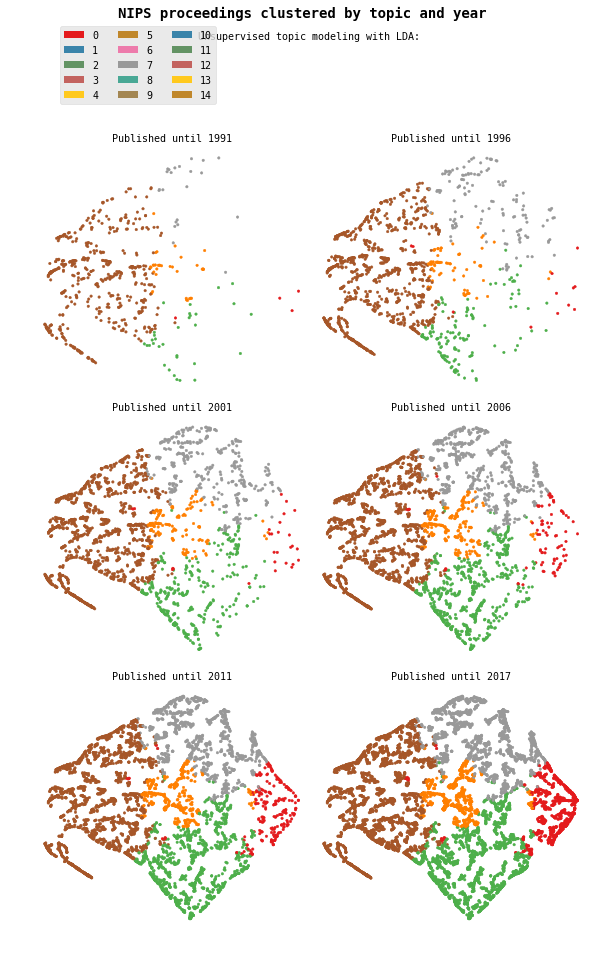

In [10]:
colors = np.array([[ 0.89411765,  0.10196079,  0.10980392,  1. ],
 [ 0.22685121,  0.51898501,  0.66574396,  1. ],
 [ 0.38731259,  0.57588621,  0.39148022,  1. ],
 [ 0.7655671 ,  0.38651289,  0.37099578,  1. ],
 [ 1.        ,  0.78937332,  0.11607843,  1. ],
 [ 0.75226453,  0.52958094,  0.16938101,  1. ],
 [ 0.92752019,  0.48406   ,  0.67238756,  1. ],
 [ 0.60000002,  0.60000002,  0.60000002,  1. ]])

legend_list = []

for i in range(len(topics)):   
    color = colors[i]
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))
    
matplotlib.rc('font',family='monospace')
plt.style.use('ggplot')


fig, axs = plt.subplots(3,2, figsize=(10, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0)

axs = axs.ravel()

count = 0
legend = []
for year, idx in zip([1991,1996,2001,2006,2011,2017], range(6)):
    data = tsne_embedding[df['year']<=year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Published until {}'.format(year),**{'fontsize':'10'})
    axs[idx].axis('off')

plt.suptitle("NIPS proceedings clustered by topic and year",**{'fontsize':'14','weight':'bold'})
plt.figtext(.51,0.95,'Unsupervised topic modeling with LDA:', **{'fontsize':'10','weight':'light'}, ha='center')


fig.legend(legend_list,topics,loc=(0.1,0.89),ncol=3)
plt.subplots_adjust(top=0.85)

plt.show()

In [11]:
#visualizing models
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()
import warnings
warnings.simplefilter("ignore", FutureWarning)

panel_lda = pyLDAvis.sklearn.prepare(lda, tf, tf_vectorizer, mds='tsne')
panel_lda

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3       20.032372 -102.919868       1        1  27.338758
1       89.350014 -149.681229       2        1  24.586793
4      164.255371 -105.916260       3        1  21.784750
0      113.458855  -39.191593       4        1  14.145546
2       32.567806  -17.076435       5        1  12.144153, topic_info=     Category           Freq        Term          Total  loglift  logprob
term                                                                     
546   Default  165113.000000       model  165113.000000  30.0000  30.0000
27    Default  118904.000000   algorithm  118904.000000  29.0000  29.0000
571   Default   77053.000000     network   77053.000000  28.0000  28.0000
378   Default   27188.000000       graph   27188.000000  27.0000  27.0000
579   Default   25024.000000        node   25024.000000  26.0000  26.0000
415   Default   51132.000000        imag   51132.000000  25.0000  25.0000
921   Default   18878.000000        tree   18878.000000  24.0000  24.0000
461   Default   32606.000000      kernel   32606.000000  23.0000  23.0000
525   Default   43177.000000      matrix   43177.000000  22.0000  22.0000
100   Default   49340.000000       bound   49340.000000  21.0000  21.0000
573   Default   24922.000000      neuron   24922.000000  20.0000  20.0000
706   Default   19296.000000        rank   19296.000000  19.0000  19.0000
136   Default   30993.000000     cluster   30993.000000  18.0000  18.0000
476   Default   24425.000000       layer   24425.000000  17.0000  17.0000
914   Default   66122.000000       train   66122.000000  16.0000  16.0000
649   Default   19764.000000      polici   19764.000000  15.0000  15.0000
850   Default   48374.000000       state   48374.000000  14.0000  14.0000
678   Default   73166.000000     problem   73166.000000  13.0000  13.0000
266   Default   13315.000000         edg   13315.000000  12.0000  12.0000
952   Default   37498.000000     variabl   37498.000000  11.0000  11.0000
430   Default   25466.000000       infer   25466.000000  10.0000  10.0000
250   Default   69367.000000   distribut   69367.000000   9.0000   9.0000
987   Default   32026.000000          xi   32026.000000   8.0000   8.0000
657   Default   14247.000000   posterior   14247.000000   7.0000   7.0000
901   Default   26883.000000     theorem   26883.000000   6.0000   6.0000
730   Default   10012.000000      regret   10012.000000   5.0000   5.0000
490   Default   16756.000000  likelihood   16756.000000   4.0000   4.0000
863   Default   32470.000000    structur   32470.000000   3.0000   3.0000
436   Default   42832.000000       input   42832.000000   2.0000   2.0000
500   Default   42755.000000         log   42755.000000   1.0000   1.0000
...       ...            ...         ...            ...      ...      ...
211    Topic5    1288.271485    decompos    2940.682688   1.2830  -6.9994
281    Topic5    3152.290596      energi    7217.989917   1.2799  -6.1046
494    Topic5    2203.705744        link    5063.547228   1.2764  -6.4626
988    Topic5    3774.580407          xj    8956.536796   1.2442  -5.9244
863    Topic5   13337.144726    structur   32470.817386   1.2185  -4.6622
952    Topic5   13273.409680     variabl   37498.271805   1.0698  -4.6669
170    Topic5    6977.620023  constraint   18615.161427   1.1271  -5.3100
782    Topic5    5057.711884      search   13601.256072   1.1191  -5.6318
27     Topic5   24830.535092   algorithm  118904.532577   0.5421  -4.0406
826    Topic5    7016.711239       solut   24250.006897   0.8682  -5.3044
678    Topic5   14438.277077     problem   73166.176104   0.4855  -4.5828
571    Topic5   14359.912561     network   77053.958544   0.4283  -4.5883
987    Topic5    8226.229885          xi   32026.317931   0.7491  -5.1454
46     Topic5    9583.163694    approxim   46183.770257   0.5357  -4.9927
592    Topic5   10476.732233      number   57446.183231   0.4066  -4.9036